In [ ]:
!pip install datasets torchvision torch

In [ ]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomErasing(p=0.3),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Validation transforms (NO random augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
class DataSetWrapper(Dataset):
  def __init__(self, dataset, label, transform = None):
    self.dataset = dataset
    self.label = label
    self.transform = transform
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, i):
    sample = self.dataset[i]
    image = sample["image"]
    if self.transform:
      image = self.transform(image)
    label = torch.tensor(self.label, dtype=torch.long)
    return image, label


In [ ]:
class Hybrid_CNN_Vit(nn.Module):
  def __init__(self, image_size = 64,
               num_classes = 2,
               cnn_channels = 32,
               num_heads = 4,
               num_layers = 1,
               dropout = 0.4):
    super().__init__()
    self.cnn = nn.Sequential( ## CNN Feature Extractor
        #32x32
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.MaxPool2d(2),
        #16x16
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.MaxPool2d(2),
        #8x8
        nn.Conv2d(64, cnn_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.MaxPool2d(2),
    )
    # Post CNN
    self.feature_h = image_size // 8
    self.feature_w = image_size //8
    self.seq_len = self.feature_h * self.feature_w
    self.embedded_dim = cnn_channels
    # Positional embeddings for tokens
    self.positional_embeddings = nn.Parameter(
        torch.randn(1, self.seq_len, self.embedded_dim)
    )
    #Transformer Encoder
    encoder_layer = nn.TransformerEncoderLayer(
        d_model = self.embedded_dim,
        nhead=num_heads,
        dim_feedforward=self.embedded_dim * 4,
        dropout=dropout,
        activation="gelu",
        batch_first=True
    )
    self.transformer = nn.TransformerEncoder(
        encoder_layer,
        num_layers=num_layers
    )
    # Classification Head
    self.clasifier = nn.Sequential(
        nn.LayerNorm(self.embedded_dim),
        nn.Dropout(0.6),
        nn.Linear(self.embedded_dim, num_classes)
    )
  def forward(self, x):
    x = self.cnn(x)
    b, c, h, w = x.shape
    x = x.view(b, c, h * w).permute(0, 2, 1)
    x += self.positional_embeddings
    x = self.transformer(x)
    x = x.mean(dim=1)
    logits = self.clasifier(x)
    return logits

In [ ]:
def accuracy_from_logits(logits, labels):
  preds = logits.argmax(dim=1)
  return (preds==labels).float().mean().item()

In [ ]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
humans = load_dataset("kevinbenoy/anime_random_images", split = "train")
ai = load_dataset("Tomisin05/generated-anime-images", split = "train")
humans_dataset = DataSetWrapper(humans, 0, transform= None)
ai_dataset = DataSetWrapper(ai, 1, transform = None)
dataset = ConcatDataset([humans_dataset, ai_dataset])



README.md:   0%|          | 0.00/286 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/523M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/562M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/285 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/180M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/21000 [00:00<?, ? examples/s]

In [ ]:
n = len(dataset)
validation_ratio = 0.2
validation_size = int(n * validation_ratio)
training_size = n - validation_size
training, testing = random_split(dataset, [training_size, validation_size])
batch_size = 128
num_workers = 2
train_transformed = TransformSubset(training, train_transform)
val_transformed = TransformSubset(testing, test_transform)
training_loader = DataLoader(train_transformed, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
testing_loader = DataLoader(val_transformed, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=True)

In [ ]:
train_class_counts = {0: 0, 1: 0}
for _, labels in training_loader:
    for label in labels:
        train_class_counts[label.item()] += 1

total = sum(train_class_counts.values())
print("Training set distribution:")
print(f"  Class 0 (Human): {train_class_counts[0]} ({100*train_class_counts[0]/total:.2f}%)")
print(f"  Class 1 (AI): {train_class_counts[1]} ({100*train_class_counts[1]/total:.2f}%)")
weight_0 = total / (2 * train_class_counts[0])
weight_1 = total / (2 * train_class_counts[1])



Training set distribution:
  Class 0 (Human): 15958 (48.70%)
  Class 1 (AI): 16810 (51.30%)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = Hybrid_CNN_Vit(dropout=0.3).to(device)
with torch.no_grad():
    model.clasifier[-1].bias.fill_(0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
class_weights = torch.tensor([weight_0, weight_1]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.2)

Using device: cuda


In [ ]:
epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5
patience_counter = 0
for epoch in range(1, epochs+1):
  #Training
  model.train()
  train_loss = 0.0
  train_accuracy = 0.0
  train_batches = 0
  for images, labels in training_loader:
    images = images.to(device)
    labels = labels.to(device)

    # lam = np.random.beta(0.4, 0.4)
    # index = torch.randperm(images.size(0)).to(device)

    # mixed_images = lam * images + (1 - lam) * images[index]
    # labels_a = labels
    # labels_b = labels[index]

    # optimizer.zero_grad()

    # logits = model(mixed_images)

    # loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)

    # loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # optimizer.step()

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits,labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()


    train_loss += loss.item()
    train_accuracy += accuracy_from_logits(logits, labels)
    train_batches += 1
  avg_train_loss = train_loss / train_batches
  avg_train_acc = train_accuracy / train_batches
  # Validation
  all_preds = []
  all_labels = []
  all_probs = []
  model.eval()
  test_loss = 0.0
  test_acc = 0.0
  test_batches = 0
  with torch.no_grad():
    for images, labels in testing_loader:
      images = images.to(device)
      labels = labels.to(device)
      logits = model(images)
      loss = criterion(logits, labels)
      probs = torch.softmax(logits, dim=1)
      preds = logits.argmax(dim=1)
      all_preds.append(preds.cpu())
      all_labels.append(labels.cpu())
      all_probs.append(probs.cpu())

      test_loss += loss.item()
      test_acc += accuracy_from_logits(logits, labels)
      test_batches += 1
  scheduler.step()
  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)
  all_probs = torch.cat(all_probs)
  avg_test_loss = test_loss / test_batches
  avg_test_acc = test_acc / test_batches

  print(
        f"Epoch {epoch:02d}: "
        f"train_loss={avg_train_loss:.4f}, train_acc={avg_train_acc:.4f}, "
        f"test_loss={avg_test_loss:.4f}, tes_acc={avg_test_acc:.4f}"
    )
  unique_preds, pred_counts = torch.unique(all_preds, return_counts=True)
  print(f"\nPredicted label distribution:")
  for pred, count in zip(unique_preds, pred_counts):
      print(f"  Class {pred}: {count} samples ({100*count/len(all_preds):.2f}%)")
  if len(unique_preds) == 1:
      print(f"⚠️ Model is predicting ONLY class {unique_preds[0]}!")
  train_losses.append(avg_train_loss)
  train_accuracies.append(avg_train_acc)
  val_losses.append(avg_test_loss)
  val_accuracies.append(avg_test_acc)
  if avg_test_loss < best_val_loss:
    best_val_loss = avg_test_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_model.pth")
  else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping!")
          break

torch.save(model.state_dict(), "cnn_vit_anime_ai_vs_human.pth")

Epoch 01: train_loss=0.4162, train_acc=0.9305, test_loss=0.4239, tes_acc=0.9355

Predicted label distribution:
  Class 0: 3595 samples (43.88%)
  Class 1: 4597 samples (56.12%)
Epoch 02: train_loss=0.4144, train_acc=0.9322, test_loss=0.4351, tes_acc=0.9291

Predicted label distribution:
  Class 0: 3506 samples (42.80%)
  Class 1: 4686 samples (57.20%)
Epoch 03: train_loss=0.4115, train_acc=0.9346, test_loss=0.4261, tes_acc=0.9390

Predicted label distribution:
  Class 0: 3629 samples (44.30%)
  Class 1: 4563 samples (55.70%)
Epoch 04: train_loss=0.4122, train_acc=0.9355, test_loss=0.4296, tes_acc=0.9336

Predicted label distribution:
  Class 0: 3573 samples (43.62%)
  Class 1: 4619 samples (56.38%)
Epoch 05: train_loss=0.4115, train_acc=0.9355, test_loss=0.4253, tes_acc=0.9445

Predicted label distribution:
  Class 0: 3696 samples (45.12%)
  Class 1: 4496 samples (54.88%)
Epoch 06: train_loss=0.4110, train_acc=0.9353, test_loss=0.4200, tes_acc=0.9508

Predicted label distribution:
  Cl

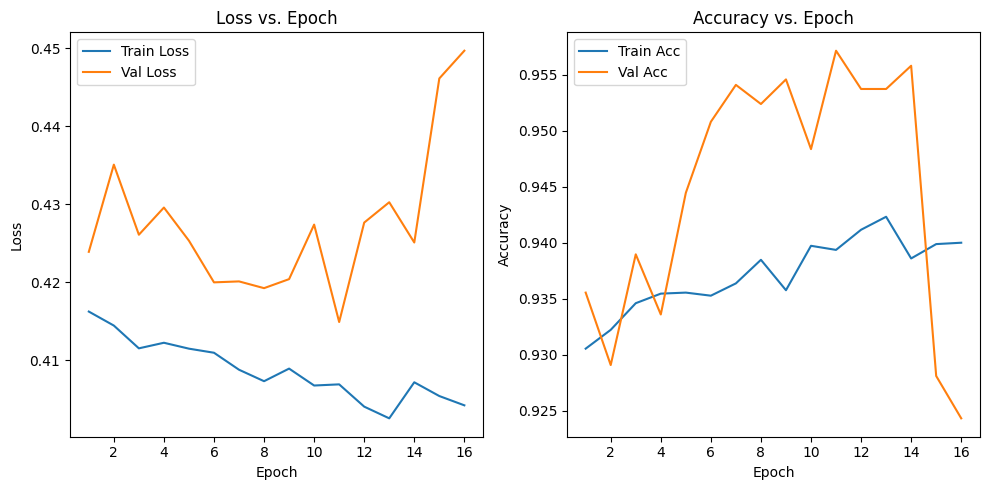

In [ ]:
# Plotting
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.tight_layout()
plt.show()

### Saving the model to Hugging Face Hub

To save your model to Hugging Face Hub, you'll need an account and a user access token. You can create a token [here](https://huggingface.co/settings/tokens) with 'write' access.

First, we'll install the `huggingface_hub` library and log in.

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import HfApi
from google.colab import userdata

# Get your Hugging Face token from Colab Secrets
HUGGINGFACE_TOKEN = userdata.get('HF_TOKEN') # Make sure to add your token as 'HF_TOKEN' in Colab Secrets

if HUGGINGFACE_TOKEN is None:
    print("Hugging Face token not found. Please add your token as 'HF_TOKEN' in Colab Secrets.")
else:
    api = HfApi()
    try:
        api.whoami(token=HUGGINGFACE_TOKEN)
        print("Successfully logged into Hugging Face Hub.")
    except Exception as e:
        print(f"Failed to log into Hugging Face Hub: {e}")
        print("Please ensure your Hugging Face token is correct and has write access.")

Successfully logged into Hugging Face Hub.


Now that you're logged in, you can create a new repository and upload your model file. You'll need to specify a `repo_id` (e.g., your_username/model_name) and provide a `commit_message`.

In [ ]:
repo_id = "Tomisin05/anime-ai-human-detector" # Replace 'your_username' with your actual Hugging Face username
file_path = "best_model.pth"
commit_message = "Upload best CNN-ViT model for anime AI/human detection"

try:
    # Create a repository if it doesn't exist
    api.create_repo(repo_id=repo_id, private=False, token=HUGGINGFACE_TOKEN, exist_ok=True)

    # Upload the model file
    api.upload_file(
        path_or_fileobj=file_path,
        path_in_repo=file_path,
        repo_id=repo_id,
        token=HUGGINGFACE_TOKEN,
        commit_message=commit_message,
    )
    print(f"Model '{file_path}' successfully uploaded to https://huggingface.co/{repo_id}/blob/main/{file_path}")
except Exception as e:
    print(f"Failed to upload model to Hugging Face Hub: {e}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  best_model.pth              : 100%|##########|  220kB /  220kB            

  best_model.pth              : 100%|##########|  220kB /  220kB            

Model 'best_model.pth' successfully uploaded to https://huggingface.co/Tomisin05/anime-ai-human-detector/blob/main/best_model.pth


Loading the Model from Hugging Face Hub for Prediction

First, we need to import `HfApi` and `hf_hub_download` from `huggingface_hub` to programmatically download your model. Then, we'll initialize your `Hybrid_CNN_Vit` model and load the downloaded state dictionary into it.

In [ ]:
from huggingface_hub import hf_hub_download

# Your Hugging Face repository ID and the filename of your model
repo_id = "Tomisin05/anime-ai-human-detector"  # Use your actual repo_id
filename = "best_model.pth"

# Download the model file
try:
    downloaded_model_path = hf_hub_download(repo_id=repo_id, filename=filename)
    print(f"Model downloaded to: {downloaded_model_path}")
except Exception as e:
    print(f"Failed to download model from Hugging Face Hub: {e}")
    print("Please ensure the repo_id and filename are correct, and your token (if private repo) is configured.")

# Initialize the model architecture
loaded_model_from_hub = Hybrid_CNN_Vit(dropout=0.3).to(device)

# Load the state dictionary
try:
    loaded_model_from_hub.load_state_dict(torch.load(downloaded_model_path, map_location=device))
    loaded_model_from_hub.eval() # Set the model to evaluation mode
    print("Model loaded successfully from Hugging Face Hub and set to evaluation mode.")
except Exception as e:
    print(f"Failed to load model state dictionary: {e}")

best_model.pth:   0%|          | 0.00/220k [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--Tomisin05--anime-ai-human-detector/snapshots/b6908e6e5c53b46f9aa80a2bfe01adfe55f2a11e/best_model.pth
Model loaded successfully from Hugging Face Hub and set to evaluation mode.


### Making Predictions with the Loaded Model

Now that the model is loaded, you can use it to make predictions on new images. We'll define a helper function to predict the class of a single image and then demonstrate it using an image from your `testing_loader`.

True Label: Human-drawn
Predicted Class: Human-drawn
Probabilities: Human-drawn: 0.7522, AI-generated: 0.2478


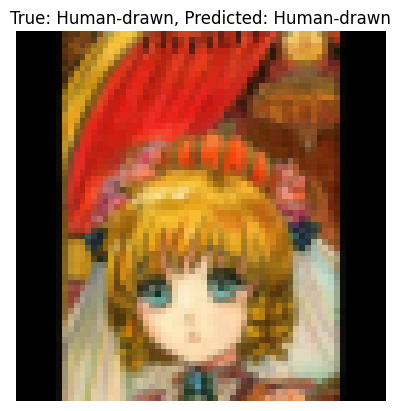

In [ ]:
def predict_image(model, image_tensor):
    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0) # Add batch dimension
        image_tensor = image_tensor.to(device)
        logits = model(image_tensor)
        probabilities = torch.softmax(logits, dim=1)
        _, predicted_class = torch.max(probabilities, 1)
    return predicted_class.item(), probabilities.cpu().numpy()[0]

# Get one sample image and label from the testing_loader
# Note: This will fetch a batch. We'll just take the first item.
for images, labels in testing_loader:
    random = np.random.randint(0, len(images))
    sample_image = images[random]
    true_label = labels[random].item()
    # sample_image = images[0] # First image in the batch
    # true_label = labels[0].item() # True label for that image
    break # Exit after getting one batch

# Make a prediction
predicted_class, probabilities = predict_image(loaded_model_from_hub, sample_image)

class_names = {0: "Human-drawn", 1: "AI-generated"}

print(f"True Label: {class_names[true_label]}")
print(f"Predicted Class: {class_names[predicted_class]}")
print(f"Probabilities: Human-drawn: {probabilities[0]:.4f}, AI-generated: {probabilities[1]:.4f}")

# Optionally, visualize the image
# Denormalize for display
img = sample_image.cpu().numpy().transpose((1, 2, 0))
img = 0.5 * img + 0.5 # Undo normalization
img = np.clip(img, 0, 1)

plt.imshow(img)
plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()